# Tarea 4 - Fashin mnist

Gustavo Alvarado. Carnet # 20063401

In [444]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import datetime

In [445]:
if tf.__version__.startswith("2."):
    import tensorflow.compat.v1 as tf
    tf.compat.v1.disable_v2_behavior()
    tf.compat.v1.disable_eager_execution()
    print("Enabled compatitility to tf1.x")

Enabled compatitility to tf1.x


## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [446]:
fashion_mnist = keras.datasets.fashion_mnist

In [447]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

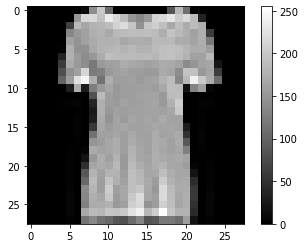

In [448]:
plt.imshow(train_images[10], cmap = 'gray')
plt.colorbar()

## Labels

In [449]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

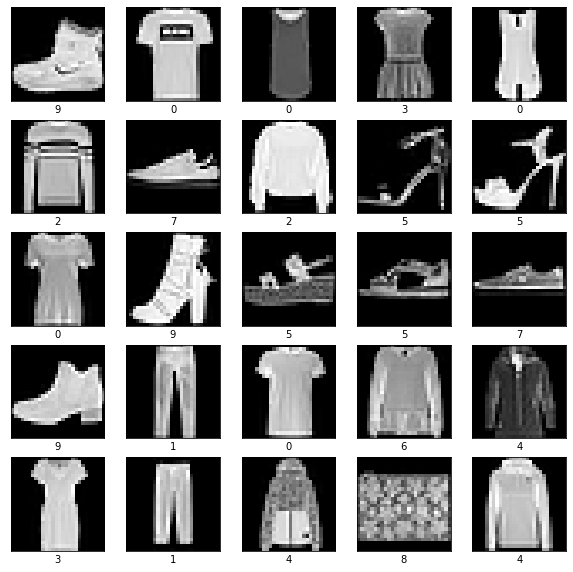

In [450]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard (agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

## Selección de clases

- Ankle boot (9)
- Sandal (5)
- Dress (3)

## Filtro de clases

In [451]:
classes = {3: "Dress", 5: "Sandal", 9: "Ankle boot"}

In [459]:
def filteringClasses(images, labels, classes):
    filtered = (labels == list(classes.keys())[0]) + (labels == list(classes.keys())[1]) + (labels == list(classes.keys())[2])
    return images[filtered], labels[filtered]

In [486]:
train_images_filtered, train_labels_filtered = filteringClasses(train_images, train_labels, classes)
test_images_filtered, test_labels_filtered = filteringClasses(test_images, test_labels, classes)

In [507]:
def predictImage(image, train_images, train_labels, classes, learning_rate, batch_size):
    n = len(train_images)
    number_classes = len(classes)
    batches = int(np.ceil(n / batch_size))
    
    image_length = len(image)
    image_width = len(image[0])
    
    now = datetime.now()
    
    #Reshaping image to predict
    image_reshaped = image.reshape(-1)
    image_reshaped = image.reshape(1, image_length * image_width)
    
    #Reshaping train images
    train_images = train_images.reshape(train_images.shape[0], -1)
    
    #One hot encoding for train labels
    df = pd.DataFrame(train_labels, columns = ['Id'])
    df = pd.get_dummies(df.Id)
    train_labels = df.values
    
    
    tf.reset_default_graph()
    
    weights = tf.get_variable("weights", dtype=tf.float32, shape=[image_length * image_width, number_classes], initializer=tf.zeros_initializer())
    
    tensor_x = tf.placeholder(tf.float32,[1, image_length * image_width],"tensor_x")
    tensor_x_train = tf.placeholder(tf.float32,[batch_size, image_length * image_width],"tensor_x_train")
    tensor_y_train = tf.placeholder(tf.float32,[batch_size, number_classes],"tensor_y_train")
    
    with tf.name_scope("logits"):
        logits = tf.matmul(tensor_x_train, weights)
    
    with tf.name_scope("softmax_cross_entropy"):
        y_estimate = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = tensor_y_train)
    
    with tf.name_scope("cost"):
        cost = tf.reduce_mean(y_estimate)
        cost_summary = tf.summary.scalar("cost", cost)
    
    with tf.name_scope("gradient_descent"):
        gradient = tf.gradients(cost, [weights])[0]
        weights_update = tf.assign(weights, weights - learning_rate * gradient)
    
    init = tf.global_variables_initializer()
    
    with tf.Session() as session:
        session.run(init)
        writer = tf.summary.FileWriter('./graphs/' + now.strftime("%d%m%Y_%H%M%S") + "_fashion", session.graph)
        
        for i in range(batches):
            batch_index = np.random.choice(n, size=batch_size)
            x_batch = train_images[batch_index]  # Transpose to the correct shape
            y_batch = train_labels[batch_index]
            feed_dict = {tensor_x: image_reshaped, tensor_x_train: x_batch, tensor_y_train: y_batch}
            cost_value = session.run(cost, feed_dict=feed_dict)
            cost_sum = session.run(cost_summary,feed_dict=feed_dict)
            writer.add_summary(cost_sum, i)
            
            session.run(weights_update, feed_dict=feed_dict)
            
            if (i % 100 == 0):
                print("Cost on iteration", i, ":", cost_value)
        
        prediction = tf.nn.softmax(tf.matmul(tensor_x, weights))
        prob_dist = session.run(prediction, feed_dict=feed_dict)
        n_predict = np.argmax(prob_dist)
        max_prob = np.round(np.max(prob_dist) * 100, 1)
        y_predict = list(classes.values())[n_predict]
        
    plt.imshow(image, cmap = 'gray')
    plt.colorbar()
    plt.xlabel("Prediction: " + y_predict + " (" + str(max_prob) + "% probability)") 

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.53115016
Cost on iteration 200 : 0.11402011
Cost on iteration 300 : 0.059608698
Cost on iteration 400 : 0.062306177
Cost on iteration 500 : 0.0015791956


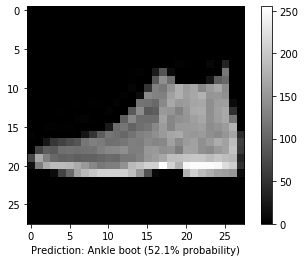

In [511]:
predictImage(test_images[0], train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

## Predicting 5 random images

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.20691605
Cost on iteration 200 : 0.4279995
Cost on iteration 300 : 0.05686935
Cost on iteration 400 : 0.075388364
Cost on iteration 500 : 0.02674485


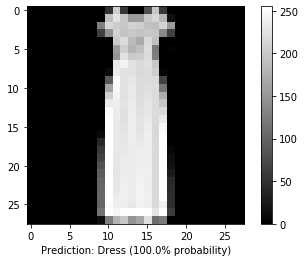

In [510]:
predictImage(test_images_filtered[np.random.randint(0, len(test_images_filtered))], 
             train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.07857209
Cost on iteration 200 : 0.034270123
Cost on iteration 300 : 0.26717472
Cost on iteration 400 : 0.120051965
Cost on iteration 500 : 0.04888653


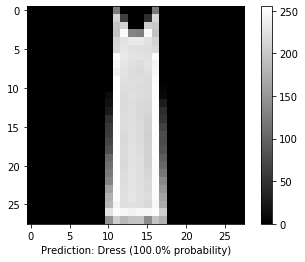

In [499]:
predictImage(test_images_filtered[np.random.randint(0, len(test_images_filtered))], 
             train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.26735735
Cost on iteration 200 : 0.13293841
Cost on iteration 300 : 0.112918586
Cost on iteration 400 : 0.10876421
Cost on iteration 500 : 0.18422669


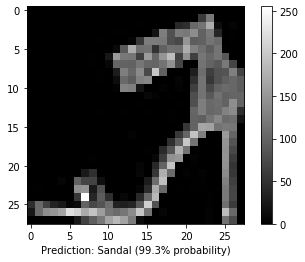

In [500]:
predictImage(test_images_filtered[np.random.randint(0, len(test_images_filtered))], 
             train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.049788743
Cost on iteration 200 : 0.41148704
Cost on iteration 300 : 0.21224931
Cost on iteration 400 : 0.2168385
Cost on iteration 500 : 0.7198223


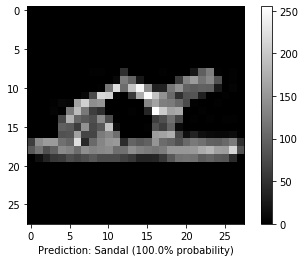

In [501]:
predictImage(test_images_filtered[np.random.randint(0, len(test_images_filtered))], 
             train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

Cost on iteration 0 : 1.0986123
Cost on iteration 100 : 0.012117902
Cost on iteration 200 : 0.0066318526
Cost on iteration 300 : 0.010756925
Cost on iteration 400 : 0.10887731
Cost on iteration 500 : 0.008272589


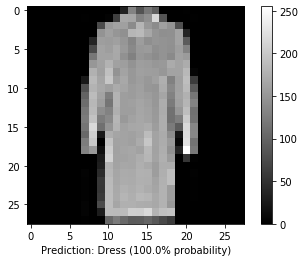

In [502]:
predictImage(test_images_filtered[np.random.randint(0, len(test_images_filtered))], 
             train_images_filtered, train_labels_filtered, classes, 0.00001, 32)

#### Grafo

<img src="./images/graph.png"></img>

#### Escalar

<img src="./images/cost.png"></img>
